In [3]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
def detect_circle(path: str, max_min_radius: tuple, return_gradient=False):
    original_pil = Image.open(path)
    gray_pil = original_pil.convert("L")
    gray = np.array(gray_pil)

    gray_blur = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,
        param1=100,
        param2=30,
        minRadius=max_min_radius[0],
        maxRadius=max_min_radius[1]
    )

    frame = cv2.cvtColor(np.array(Image.open(path)), cv2.COLOR_RGB2BGR)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)

        x, y, r = circles[0]
        cv2.circle(frame, (x, y), r, (0, 255, 0), 4)
        n = 15
        r_reduced = max(1, r - n)
        cv2.circle(frame, (x, y), r_reduced, (255, 0, 255), 2)

        mask = np.zeros_like(gray)
        cv2.circle(mask, (x, y), r_reduced, (255, 255, 255), -1)
        masked = cv2.bitwise_and(gray, mask)

    if return_gradient:
        ys, xs = np.where(masked > 0)
        intensities = masked[ys, xs]
        X = np.column_stack((xs, ys))
        y = intensities
        model = LinearRegression().fit(X, y)
        a, b = model.coef_
        c = model.intercept_
        gradient_image = np.zeros_like(masked, dtype=np.float32)
        for x, y in zip(xs, ys):
            gradient_image[y, x] = a * x + b * y + c

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        im0 = axes[0].imshow(frame)
        fig.colorbar(im0, ax=axes[0])
        im1 = axes[1].imshow(masked, cmap='gray')
        fig.colorbar(im1, ax=axes[1])
        im2 = axes[2].imshow(gradient_image, cmap='gray')
        fig.colorbar(im2, ax=axes[2])
        plt.show()

        return mask, masked, gradient_image

    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im0 = axes[0].imshow(frame)
        fig.colorbar(im0, ax=axes[0])
        im1 = axes[1].imshow(masked, cmap='gray')
        fig.colorbar(im1, ax=axes[1])
        plt.show()

        return masked


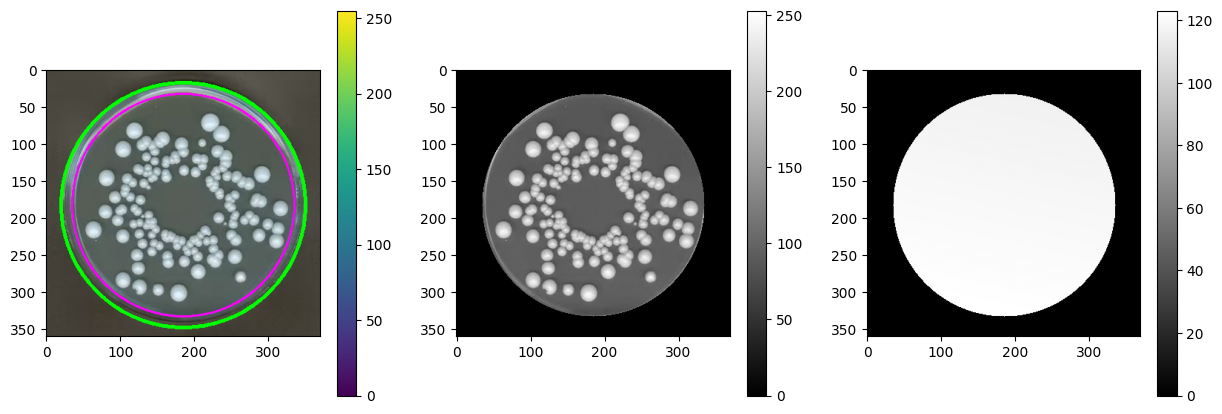

In [6]:
mask, masked, gradient_image = detect_circle("placa real.jpg", (100,210),True)

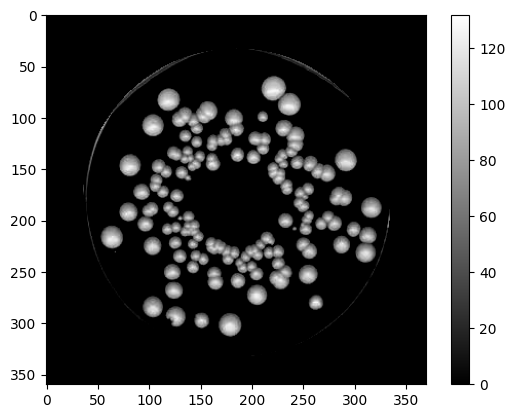

In [7]:
sem_luz = masked-gradient_image
sem_luz_uint8 = np.clip(sem_luz, 0, 255).astype(np.uint8)
sem_luz_norm = cv2.bitwise_and(sem_luz_uint8, mask)


plt.imshow(sem_luz_norm,cmap='gray')
plt.colorbar()


0.17788373113000666


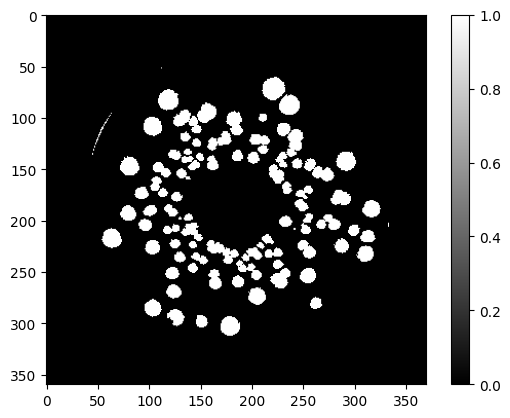

In [9]:
filtro = sem_luz>60
plt.imshow(filtro,cmap='gray')
plt.colorbar()
area_coberta = np.count_nonzero(filtro)/np.count_nonzero(masked)
print(area_coberta)

0.17788373113000666

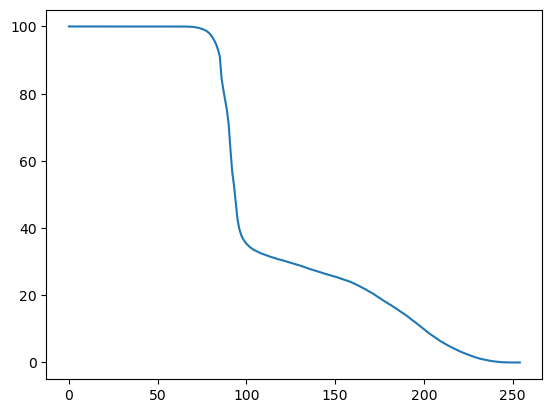

In [ ]:
porcentagens = []
valor_i = []

for i in range(0,255):
   filtro = masked>i
   porcentagens.append((np.count_nonzero(filtro)/np.count_nonzero(masked))*100)
   valor_i.append(i)
   
plt.plot(valor_i,porcentagens)

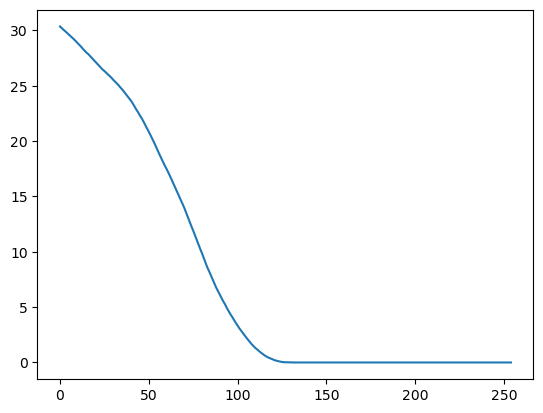

In [ ]:
porcentagens = []
valor_i = []

for i in range(0,255):
   filtro =sem_luz_norm>i
   porcentagens.append((np.count_nonzero(filtro)/np.count_nonzero(masked))*100)
   valor_i.append(i)

plt.plot(valor_i,porcentagens)